# Bank loan model : The big picture


This case is about a bank (**Thera Bank**) which has a growing customer base.


Majority of these customers are **liability customers** (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and **the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans**. 


In particular, the management wants to **explore ways of converting its liability customers to personal loan customers (while retaining them as depositors)**. 


A campaign that the bank ran last year for liability customers showed **a healthy conversion rate of over 9% success**. 


This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.




## Framing the problem


### What is the business objective ?


The department wants to build a model that will **help them identify the potential customers who have a higher probability of purchasing the loan**. 

**This will increase the success ratio while at the same time reduce the cost of the campaign**.



**Impact of errors**: <br>
- False negatives (**eligible customers rejected**) can lead to **revenue losses** for the bank.<br>
- False positives (**ineligible customers accepted**) can lead to **payment default risks**.<br>


### What is the type of learning ?



With the gathered information, we are ready to design our system.<br>

- This is a **supervised learning task** because the model can train on labeled examples (customers who actually purchased a loan). <br>


- It’s a **classification task** since the goal is to predict the likelihood of customers to purchase a loan or not. <br>



## Selecting a performance measure


The next step is to choose a performance measure: <br>
- **Recall** may be favored if the goal is **to minimize false negatives**, 
- or **F1-score** to **balance precision and recall**.



We will compute : <br>



- the F1 score :    $$F_1  = \frac{2}{\frac{1}{precision}+ \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP +  \frac{FN + FP}{2}} $$ <br><br>

- the recall : $$recall  = \frac{TP}{TP + FN}$$<br>


- the precision :  $$precision  = \frac{TP}{TP + FP}$$ <br>



with **TP** : True Positives and **FN** : False Negatives


# Getting the data


## Import libraries


Here will be imported all the necessary libraries that we'll use for this task !

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

# General libraries
import pandas as pd
pd.set_option('display.width', None)
import numpy as np
import math
from scipy.stats import iqr
import random


# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import plotly.express as px

# Split train set and test set
from sklearn.model_selection import train_test_split

# Geolocation libraries
import pgeocode 
from geopy.geocoders import Nominatim

# Preprocessing the data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer


# Models
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb


# Scores
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

# Saving/loading models
import joblib


## Import the data


We import the data and store it locally.

In [2]:
# Retrieve the data stored locally
path = "../data/raw_data"
banking_data = pd.read_excel(path + "/Bank_Personal_Loan_Modelling.xlsx", sheet_name="Data")

banking_data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
print(f"The data shape is : {banking_data.shape}")

The data shape is : (5000, 14)


## Describe the features


We have the following features : <br>
**ID**: Customer ID<br>
**Age**: Customer's age in completed years<br>
**Experience**: #years of professional experience<br>
**Income**: Annual income of the customer (**in thousands of dollars**) <br>
**ZIP_Code**: Home Address ZIP code.<br>
**Family**: Family size of the customer <br>
**CCAvg**: Avg. spending on credit cards per month (**in thousands of dollars**)<br>
**Education**: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional<br>
**Mortgage**: Value of house mortgage if any (**in thousands of dollars**).<br>
**Personal Loan**: Did this customer accept the personal loan offered in the last campaign?<br>
**Securities Account**: Does the customer have a securities account with the bank?<br>
**CD Account**: Does the customer have a certificate of deposit (CD) account with the bank?<br>
**Online**: Does the customer use internet banking facilities?<br>
**CreditCard**: Does the customer use a credit card issued by UniversalBank?<br>




### FAST API info on features



#### Descritpion (FastApi)



In [4]:
# summary of the DataFrame
banking_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [5]:
# Create detailed summary of dataframe
cols_count_df = pd.DataFrame(banking_data.notnull().count(), columns=['Non-Null Count'])
cols_dtypes_df = pd.DataFrame(banking_data.dtypes, columns=['Dtype'])

# Describe the features
cols_description_df = pd.DataFrame(
    {
        '' : ['ID',
              'Age',
              'Experience',
              'Income',
              'ZIP Code',
              'Family',
              'CCAvg',
              'Education',
              'Mortgage',
               'Personal Loan',
              'Securities Account',
              'CD Account',
              'Online', 'CreditCard'],

        'feature_description' : ["Customer ID",
                                 "Customer's age in completed years",
                                 "#years of professional experience",
                                "Annual income of the customer (in thousands of dollars)",
                                 "Home Address ZIP code",
                                 "Family size of the customer",
                                 "Avg. spending on credit cards per month (in thousands of dollars)",
                                 "Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional",
                                 "Value of house mortgage if any (in thousands of dollars)",
                                 "Did this customer accept the personal loan offered in the last campaign?",
                                 "Does the customer have a securities account with the bank?",
                                 "Does the customer have a certificate of deposit (CD) account with the bank?",
                                 "Does the customer use internet banking facilities?",
                                 "Does the customer use a credit card issued by UniversalBank?"]
    },
    index = range(len(banking_data.columns))
)
cols_description_df = cols_description_df.set_index(keys=[''])


# Describe the type of features (numerical or categorical)
cols_catnum_description_df = pd.DataFrame(
    {
        '' : ['ID',
              'Age',
              'Experience',
              'Income',
              'ZIP Code',
              'Family',
              'CCAvg',
              'Education',
              'Mortgage',
               'Personal Loan',
              'Securities Account',
              'CD Account',
              'Online', 
              'CreditCard'],

        'Feature type' : ["Numerical", 
                         "Numerical",
                         "Numerical",
                         "Numerical",
                         "Numerical",
                         "Categorical",
                         "Numerical",
                         "Numerical",
                         "Numerical",
                         "Categorical",
                         "Categorical",
                         "Categorical",
                         "Categorical",
                         "Categorical"]
    },
    index = range(len(banking_data.columns))
)
cols_catnum_description_df = cols_catnum_description_df.set_index(keys=[''])


# Merging
merged = pd.merge(cols_description_df,cols_dtypes_df, how='inner', left_index=True, right_index=True)
merged = pd.merge(merged,cols_catnum_description_df, how='inner', left_index=True, right_index=True)
merged = pd.merge(merged,cols_count_df, how='inner', left_index=True, right_index=True)

#Display                    
display(merged)                              

,feature_description,Dtype,Feature type,Non-Null Count
ID,Customer ID,int64,Numerical,5000
Age,Customer's age in completed years,int64,Numerical,5000
Experience,#years of professional experience,int64,Numerical,5000
Income,Annual income of the customer (in thousands of...,int64,Numerical,5000
ZIP Code,Home Address ZIP code,int64,Numerical,5000
Family,Family size of the customer,int64,Categorical,5000
CCAvg,Avg. spending on credit cards per month (in th...,float64,Numerical,5000
Education,Education Level. 1: Undergrad; 2: Graduate; 3:...,int64,Numerical,5000
Mortgage,Value of house mortgage if any (in thousands o...,int64,Numerical,5000
Personal Loan,Did this customer accept the personal loan off...,int64,Categorical,5000


#### Correlation (Fast API)

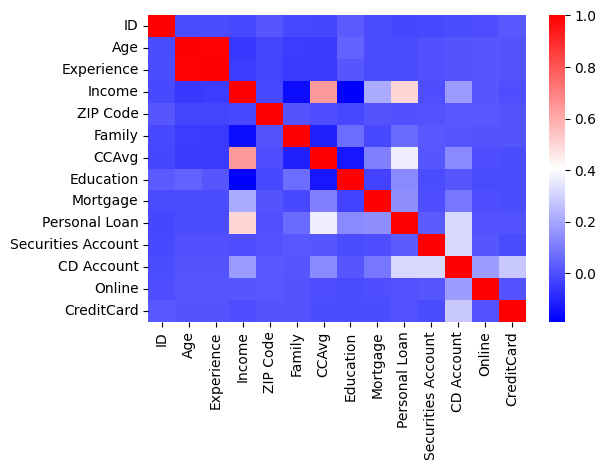

In [6]:
# Heatmap of pairwise correlations
correlation_matrix = banking_data.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, 
            xticklabels=column_names, 
            yticklabels=column_names,
            cmap= "bwr");
plt.tight_layout()
plt.show()

In [7]:
print i

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (1927283887.py, line 1)

## Rewrite feature names


Updating the feature names for easier use.


In [ ]:
# Updating the feature names for easier use.
banking_data = banking_data.rename(columns={
                                            "ZIP Code":"ZIP_Code", 
                                            "Personal Loan":"Personal_Loan",
                                            "Securities Account":"Securities_Account",
                                            "CD Account": "CD_Account"
                                            })

banking_data.head(2)

## Dropping features


We won't need the **ID column**. Let's drop it !



In [ ]:
# We won't need the ID column. Let's drop it !
banking_data = banking_data.drop(columns=['ID'])
banking_data.head(2)

## Cleaning the data

### Processing duplicates

We check the number of duplicated rows.

In [ ]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(banking_data)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {banking_data.duplicated().sum()}")

# Remove duplicates
banking_data = banking_data.drop_duplicates() 

# Check number of rows before removing duplicates
print(f"Number of rows (AFTER dropping duplicates) : {len(banking_data)}")

There are no duplicated rows .


### Processing missing data




We check the percentage of missing values in the data at hand.

In [ ]:
def get_missing_data(data):       
    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent
    return missing_data

missing_data = get_missing_data(banking_data)
missing_data

We don't have any missing values.


## Create longitude and latitude


It would be interesting to locate **geographically** each customer.<br>

Let's extract the coordinates (longitude and latitude) of each customer, through their ZIP code.


In [ ]:
# Retrieve geographical info from zip code
ZIP_Codes = banking_data['ZIP_Code'].values.astype('str').tolist()
nomi = pgeocode.Nominatim('us')
df_PostalCode = nomi.query_postal_code(ZIP_Codes)
df_PostalCode['postal_code'] = df_PostalCode['postal_code'].values.astype('int64')

# Check
print(df_PostalCode.shape)
df_PostalCode.head()


We could extract the customers coordinates thanks to their Zip code.


Now, let's check for duplicated rows of coordinates dataframe.


In [ ]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(df_PostalCode)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {df_PostalCode.duplicated().sum()}")

# Remove duplicates
df_PostalCode = df_PostalCode.drop_duplicates() 

# Check number of rows before removing duplicates
print(f"Number of rows (AFTER dropping duplicates) : {len(df_PostalCode)}")

Now, let's add the coordinates of each customer to our banking data.



In [ ]:
# Create latitude and longitude columns
banking_data = pd.merge(banking_data,df_PostalCode[['postal_code', 'latitude', 'longitude']],
                        how='left',
                        left_on='ZIP_Code',
                        right_on='postal_code')

# Dropping postal_code (not needed anymore)
banking_data = banking_data.drop(columns='postal_code')

# Check
print(banking_data.shape)
banking_data.head(5)

**Let's check for missing data after creating longitude and latitude features!** 


In [ ]:
missing_data = get_missing_data(banking_data)
missing_data

**Less than 1%** of data is missing for latitude and longitude. We drop the rows with missing data.


In [ ]:
# Less than 1% of data is missing for latitude and longitude. We drop the rows with missing data.
print(f"Number of rows  (BEFORE DROPPING) : {banking_data.shape}")
banking_data = banking_data.dropna()
print(f"Number of rows  (AFTER DROPPING) : {banking_data.shape}")


**Let's check for missing data again.** 


In [ ]:
# Let's check for missing data again.
get_missing_data(banking_data.dropna())

We don't have missing values anymore.



**Let's drop the ZIP_Code column.** 


In [ ]:
# # Let's drop the ZIP_Code column.
# banking_data = banking_data.drop(columns="ZIP_Code")

# Exploring the data


## Quick exploration

In [ ]:
# summary of the DataFrame
banking_data.info()

In [ ]:
# Descriptive statistics
banking_data.describe()

In [ ]:
# Histogram of the DataFrame’s columns
banking_data.hist(bins=150, figsize=(12, 8))
plt.tight_layout()
plt.show()

## Test set and train set

### Check target balance


Our target is **Personal_Loan**. <br> 
Let's check the balance of the target.


In [ ]:
# Our target is Personal_Loan. Let's check the balance of the target.
banking_data.Personal_Loan.value_counts()/len(banking_data)*100

**The data is very imbalanced !!**


Imbalanced dataset is a dataset where the classes are not balanced or equal.<br>
This means there are an unequal number of samples from each target class and some classes may have significantly more samples than others.


### Problems with Imbalanced Datasets


Imbalanced datasets can lead to algorithms that are biased towards the majority class. <br>


This means that any classification algorithm trained on an imbalanced dataset will often inaccurately classify minority classes as the majority class.


The performance of a machine learning model can become highly skewed when it is fed with imbalanced data.<br>

For example, our dataset has 90% class 0 and 10% class 1, then the learning model could be easily optimized to just predict all test input as belonging to class 0 and still get 90% accuracy!


If a model is trained on data which is heavily imbalanced, it can develop an incorrect understanding of the underlying trends in the data. The model may not be able to recognize how certain values are distributed among different classes or even how certain classes overlap with each other.

### Techniques to Handle Imbalanced Dataset



#### The approach to train test split


The approach to train test split when dealing with imbalanced datasets is to use **stratification**.<br>


Stratification is an important step in splitting imbalanced datasets into training and test sets.<br>

Stratification ensures that the proportion of each class remains the same across both the training and test sets.<br>

This is important as it allows for a more accurate evaluation of the model, avoiding bias due to a disproportion of one class being over-represented in either dataset. <br>

Stratified sampling also ensures that any trends or correlations among different classes that exist within the overall dataset are preserved after splitting into training and test datasets.


### Train set and test set: Stratification



We split the data in : <br>
- a train on which we will train our final model
- a test set we will use to evaluate the model (in the end)

In [ ]:
# Create train set and test set (stratified based on median incom categories)
strat_train_set, strat_test_set = train_test_split(
    banking_data, test_size=0.2, stratify=banking_data["Personal_Loan"], random_state=42)

In [ ]:
# Check of stratified train set
strat_train_set.Personal_Loan.value_counts()/len(strat_train_set)*100

In [ ]:
# Check of stratified test set
strat_test_set.Personal_Loan.value_counts()/len(strat_test_set)*100

## Explore and visualizing the data to gain insights


We use a copy of the stratified train set to explore the data.


In [ ]:
# Create a copy of the stratified train set before exploring
bank = strat_train_set.copy()

Let's save the explorated data as CSV file (used for exploration purpose in Google Looker Studio).


In [ ]:
# # Let's save the explorated data as CSV file (used for exploration purpose in Google Looker Studio).
# path_save = "../data/processed_data/strat_train_set.csv"
# bank.to_csv(path_save, index=False)

Let's look at the type of the features !


In [ ]:
# Type of features 
continuous_feats = ['CCAvg', 'latitude', 'longitude', 'ZIP_Code']
discrete_feats = ['Experience', 'Income', 'Mortgage']
categorical_feats = ['Education','Personal_Loan', 'Family']
binary_feats = ['Securities_Account','CD_Account','Online','CreditCard']

### Univariate analysis


#### Numerical features



In [ ]:
# Numerical features
numerical_feats = continuous_feats + discrete_feats
numerical_feats

Let's plot the histograms of the numerical features.

In [ ]:
# Plot histograms
ncol_max = 3
nrow_max = math.ceil(len(numerical_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# Histograms
for col in numerical_feats:  
        # Plotting the histograms
        sns.histplot(data = bank[numerical_feats], 
                     x= bank[col], 
                     kde = True,                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Hist Plot - {col}')
        
# Hide unused subplots
for ax in axs[len(numerical_feats):]:
    ax.axis('off')
    
# Adjust layout
plt.tight_layout()
plt.show()

Let's plot the violin plots of the numerical features .


In [ ]:
# Plot violin plots
ncol_max = 3
nrow_max = math.ceil(len(numerical_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in numerical_feats:  
        # Plotting the violin plots
        sns.violinplot(data = bank[numerical_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Violin Plot - {col}')  

# Hide unused subplots
for ax in axs[len(numerical_feats):]:
    ax.axis('off')
    
# Adjust layout
plt.tight_layout()
plt.show()


Let's plot the boxplots of the numerical features.

In [ ]:
# Plot boxplots
ncol_max = 3
nrow_max = math.ceil(len(numerical_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in numerical_feats:  
        # Plotting the boxplots
        sns.boxplot(data = bank[numerical_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Box Plot - {col}')  
        
# Hide unused subplots
for ax in axs[len(numerical_feats):]:
    ax.axis('off')
    
# Adjust layout
plt.tight_layout()
plt.show()


**Insights** :

- CCAvg : The median spending on credit card per month is **around 1500 USD**.
- Age : The median age is **around 45 years old**.
- Experience : The median number of years of professional experience is **around 20 years**.
- Income : The median income is around **70 000 USD**.


#### Categorical features



In [ ]:
# Categorical features
categories_feats = categorical_feats + binary_feats
categories_feats

In [ ]:
# Plot count plots
ncol_max = 3
nrow_max = math.ceil(len(categories_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))

# Flatten axes for easy iteration
axs = axs.flatten()

# countplots
for col in categories_feats:         
        # Plotting the count plots
        sns.countplot(data = bank[categories_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[categories_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[categories_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[categories_feats].columns.get_loc(col)].set_title(f'Bar Plot - {col}')  
        axs[bank[categories_feats].columns.get_loc(col)].bar_label(            
            axs[bank[categories_feats].columns.get_loc(col)].containers[0],
            fontsize=8
            )       

# Hide unused subplots
for ax in axs[len(categories_feats):]:
    ax.axis('off')
           
# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Plot pie charts
ncol_max = 3
nrow_max = math.ceil(len(categories_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))

# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in categories_feats:  
        # Example DataFrame
        data = pd.DataFrame({'Category': bank[col].value_counts().index.values, 
                             'Values': bank[col].value_counts().values})

        # Create a pie chart
        data.set_index('Category').plot.pie(y='Values',
                                            autopct='%1.1f%%', 
                                            ax = axs[bank[categories_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[categories_feats].columns.get_loc(col)].set_title(f'{col}') 
        axs[bank[categories_feats].columns.get_loc(col)].set_ylabel('')              

# Hide unused subplots
for ax in axs[len(categories_feats):]:
    ax.axis('off')
    
# Adjust layout
plt.tight_layout()
plt.show()

### Bivariate analysis


#### Correlation


What is the correlation between the numericals features ?

In [ ]:
# Heatmap of pairwise correlations
correlation_matrix = bank[numerical_feats].corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, 
            xticklabels=column_names, 
            yticklabels=column_names,
            cmap= "bwr",
           annot=True);
plt.tight_layout()
plt.show()

In [ ]:
#Create a dataframe listing pair correlations and absolute correlations
correlation_matrix = bank[numerical_feats].corr()

# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

corr_df.sort_values(by="absolute_correlation", ascending=False, inplace = True)
corr_df.head(10)


We see that **Experience** and **Age** have **more than 99% correlation**.<br>
We may drop one of these later on.


We see that **latitude** and **longitude** have **more than 94% correlation**.<br>
We may drop one of these later on.


There is a high correlation between **ZIP_Code** and **latitude** (i.e **86%**) and between **ZIP_Code** and **longitude** (i.e **81%**).<br>
We may drop on of these later on.


#### Scatter matrix


In [ ]:
# Display scatter matrix for numerical
scatter_matrix(bank[numerical_feats], figsize= (12,8))
plt.show()

### Visualizing Geographical data


We locate each customer based on their coordinates.


In [ ]:
# Visualize geographic data using scatter_mapbox
fig = px.scatter_mapbox(bank, 
                         lat='latitude', 
                         lon='longitude', 
                         center=dict(lat=37, lon=-120),
                         size_max=20,
                         zoom=4,
                         # size='Personal_Loan',
                         color='Personal_Loan',
                         height=600,
                         title='<b> Visualize geographic data using scatter_mapbox</b>',
                         color_continuous_scale=px.colors.sequential.Viridis)

fig.update_layout(mapbox_style='open-street-map', height=600)
fig.show()


# Prepare the data for Machine Learning Algorithms


We separate the features from the target.

We drop some features to avoid redundancy of information.


In [ ]:
# We drop some features to avoid redundancy of information.
cols_to_drop = ['Age', 'longitude','latitude']

In [ ]:
# Separate featues from target
X = strat_train_set.drop(["Personal_Loan"] + cols_to_drop, axis=1)
y = strat_train_set["Personal_Loan"].copy()

In [ ]:
# Display the shapes of features and target
print(f"The shape of X : {X.shape}")
print(f"The shape of y : {y.shape}")

## Handling text and categorical attributes

The categorical features and binary features have numerical data types.<br>
For computational reasons, we'll process them as numerical features for scaling.


## Checking for outliers in numerical features


Let's check the outliers of the numerical columns.


In [ ]:
# Plot boxplots of each numerical column
plt.figure(figsize=(10, 20))

# for column in housing_num_tr.columns: 
for i, column in enumerate(X.columns, 1):
    plt.subplot(13, 3, i)
    sns.boxplot(x=X[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


In [ ]:
# Plot boxplots of each numerical column
plt.figure(figsize=(10, 20))

# for column in housing_num_tr.columns: 
for i, column in enumerate(X.columns, 1):
    plt.subplot(13, 3, i)
    sns.boxplot(x=X[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

It would be useful to extract the features containing outliers **automatically**. It will be used for pipeline implementation.


Let's extract the features with outliers **numerically** !


In [ ]:
# Identify the columns with outliers
numerical_columns_w_outliers = []
numerical_columns_no_outliers = []

for col in X.columns: 
    # Calculate IQR
    iqr_value = iqr(X[col])

    #Calculate 1st quartile
    q1 = np.percentile(X[col],25)

    #Calculate 3rd quartile
    q3 = np.percentile(X[col],75)

    #Calculate lower limit below which data point is considered an outlier
    outlier_lim_low = q1 - 1.5 * iqr_value

    #Calculate higher limit above which data point is considered an outlier
    outlier_lim_high = q3 + 1.5 * iqr_value
    
    #Calculate number of 'low' outliers
    outlier_condition_low = X[col] < outlier_lim_low
    number_outliers_low = len(X[outlier_condition_low][col])
    
    #Calculate number of 'high' outliers
    outlier_condition_high = X[col] > outlier_lim_high
    number_outliers_high = len(X[outlier_condition_high][col])
    
    #Calculate total number of outliers
    number_outliers_total = number_outliers_low + number_outliers_high
      
    #If any outliers in column, column is added to a list of columns with outliers
    if number_outliers_total > 0:
        numerical_columns_w_outliers.append(col)
    elif number_outliers_total == 0:
        numerical_columns_no_outliers.append(col)     
        

Let's check if we could extract the outliers **numerically** !



In [ ]:
print(f"The features having outliers are : {numerical_columns_w_outliers}")
print(f"The features WITHOUT outliers are : {numerical_columns_no_outliers}")

## Feature scaling and transformation


**WHY SCALING ??**

❗️ Features with large magnitudes can incorrectly outweigh features of small magnitudes <br>
⚡️ Scaling to smaller magnitudes improves computational efficiency <br>
🕵🏻‍♂️ Increases interpretability about the impact of each feature in a Machine Learning model <br>

### Columns with outliers


<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>

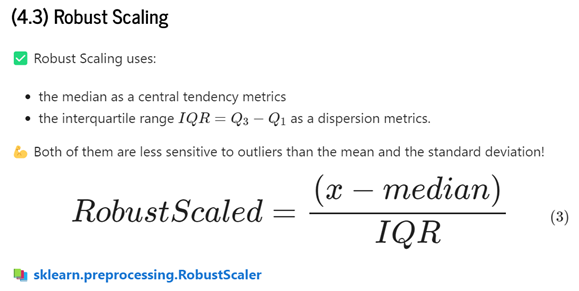


In [ ]:
# Reminder of features with outliers
display(numerical_columns_w_outliers)

Let's have a look of the statistics of numerical columns with outliers (**BEFORE SCALING**).

In [ ]:
# Describe columns with outliers
X[numerical_columns_w_outliers].describe()

In [ ]:
# Instantiate Robustscaler
robust_scaler = RobustScaler()

# Fit and transform
X[numerical_columns_w_outliers] = robust_scaler.fit_transform(X[numerical_columns_w_outliers])
X[numerical_columns_w_outliers].head(3)

Now, let's check the statistics of the numerical columns with outliers (**AFTER SCALING**).

In [ ]:
# Describe columns with outliers
X[numerical_columns_w_outliers].describe()

### Columns without outliers


<span style="font-family:Comic Sans MS; color:red">We consider using MinMax scaling for columns WITHOUT outliers !  </span>

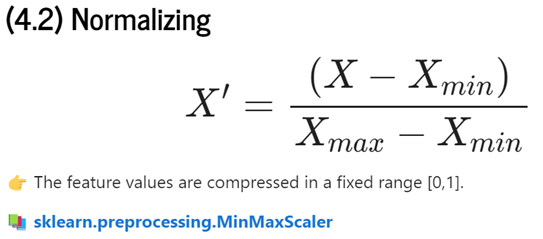
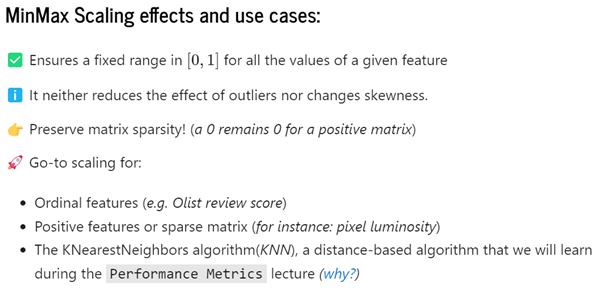


Let's have a look of the statistics of numerical columns without outliers (**BEFORE SCALING**).

In [ ]:
# Describe columns with NO outliers
X[numerical_columns_no_outliers].describe()

In [ ]:
#Instanciate, fit, transform with minmax scaler
minmax_scaler = MinMaxScaler()
X[numerical_columns_no_outliers] = minmax_scaler.fit_transform(X[numerical_columns_no_outliers])

Now, let's check the statistics of the numerical columns without outliers (**AFTER SCALING**).

In [ ]:
# Describe columns with NO outliers
X[numerical_columns_no_outliers].describe()

## Create pipelines


In [ ]:
# Create pipelines
preprocessing = make_column_transformer(
                                        (RobustScaler(), numerical_columns_w_outliers),
                                        (MinMaxScaler(), numerical_columns_no_outliers),
#                                         remainder='passthrough'
                                        )

preprocessing.fit(X)

# Oversampling the minority class for training using SMOTE


In [ ]:
# Separate featues from target
X = strat_train_set.drop(["Personal_Loan"] + cols_to_drop, axis=1)
y = strat_train_set["Personal_Loan"].copy()

In [ ]:
# Check of stratified train set
y.value_counts()/len(strat_train_set)*100

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
# Check of stratified train set
y_smote.value_counts()/len(y_smote)*100

# Train and evaluate on the training set with several models

Now, let's use several classification models.


In [ ]:
%%time

# Selection of models to try out
classification_models = [LogisticRegression(random_state=42), 
                         LinearSVC(random_state=42), 
                         RandomForestClassifier(),
                         XGBClassifier()]
mean_recall_scores = {}
mean_precision_scores = {}
mean_f1_scores = {}

# Train and evaluate the models
for model in classification_models:
    piped_model = make_pipeline(preprocessing, model)
    piped_model.fit(X, y)
    scores = cross_validate(piped_model, X_smote, y_smote, cv=20, scoring=['recall', 'precision', 'f1'])
    
    #Calculate mean scores     
    mean_recall_score = scores['test_recall'].mean()
    mean_precision_score = scores['test_precision'].mean()
    mean_f1_score = scores['test_f1'].mean()
    
    # Store mean scores in dicts     
    mean_recall_scores[str(model)[:str(model).find('(')]] = mean_recall_score
    mean_precision_scores[str(model)[:str(model).find('(')]] = mean_precision_score
    mean_f1_scores[str(model)[:str(model).find('(')]] = mean_f1_score
 
    
# Formatting the results into a dataframe (RECALL)
mean_recall_scores_df = pd.DataFrame(mean_recall_scores, index=[0])
mean_recall_scores_df = mean_recall_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'recall', 'index' : 'Model'})\
                                .sort_values('recall', ascending=False)

# Formatting the results into a dataframe (PRECISION)
mean_precision_scores_df = pd.DataFrame(mean_precision_scores, index=[0])
mean_precision_scores_df = mean_precision_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'precision', 'index' : 'Model'})\
                                .sort_values('precision', ascending=False)

# Formatting the results into a dataframe (F1)
mean_f1_scores_df = pd.DataFrame(mean_f1_scores, index=[0])
mean_f1_scores_df = mean_f1_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'F1', 'index' : 'Model'})\
                                .sort_values('F1', ascending=False)

# Merge
merged = pd.merge(mean_recall_scores_df,mean_precision_scores_df,
                        how='left',
                        left_on='Model',
                        right_on='Model')


merged = pd.merge(merged,mean_f1_scores_df,
                        how='left',
                        left_on='Model',
                        right_on='Model').sort_values('recall', ascending=False)
                
display(merged)

**XGBClassifier** has the **best recall**, **best precision**  and **best F1 score**.


# Fine tune the model


Let's fine tuned our chosen model (**XGB Classifier**).



## Grid Search

In [ ]:
# Reminder of the pipeline structure
XGBClassifier_pipe= make_pipeline(preprocessing, XGBClassifier())
XGBClassifier_pipe


What are the available hyper parameters of the classifier and preprocessing pipeline ?



In [ ]:
# Get the pipeline parmeters
XGBClassifier_pipe.get_params().keys()

In [ ]:
%%time
# Create grid
param_distribs = {
    'xgbclassifier__learning_rate' : [0.01, 0.1, 0.3],
    'xgbclassifier__n_estimators' : [100, 200],
    'xgbclassifier__subsample' : [0.5, 1],
    'xgbclassifier__colsample_bytree': [0.3, 0.5],
    'xgbclassifier__reg_alpha' : [0, 0.5], 
    'xgbclassifier__reg_lambda' : [1,5]
}

# Perform Grid Search
grid_search = GridSearchCV(XGBClassifier_pipe, 
                           param_grid = param_distribs, 
                           cv=5,
                           scoring=['recall', 'precision', 'f1'],
                           refit='f1')

# Fit data to Grid Search
grid_search.fit(X_smote, y_smote)

The best hyperparameter combination found:

In [ ]:
# Get the best params found
grid_search.best_params_

In [ ]:
# Get the best estimator found
grid_search.best_estimator_

👎 Limitations of Grid Search:<br>
•	Computationally costly <br>
•	The optimal hyperparameter value can be missed <br>
•	Can overfit hyperparameters to the training set if too many combinations are tried out for too small a dataset

So let's try a **random grid search** !

## Random search

Randomly explore hyperparameter values from: <br>
•	A hyperparameter space to randomly sample from <br>
•	The specified number of samples to be tested

In [ ]:
%%time
# Create grid
param_distribs = {
    'xgbclassifier__learning_rate' : [round(np.random.uniform(0,1),2)],
    'xgbclassifier__n_estimators' : [random.randint(100, 200)],
    'xgbclassifier__subsample' : [round(np.random.uniform(0,1),1)],
    'xgbclassifier__colsample_bytree': [round(np.random.uniform(0,1),1)],
    'xgbclassifier__reg_alpha' : [round(np.random.uniform(0,1),1)], 
    'xgbclassifier__reg_lambda' : [random.randint(1, 5)]
}

# Perform Grid Search
rnd_search = RandomizedSearchCV(XGBClassifier_pipe, 
                                param_distributions=param_distribs,
                                cv=5,
                                scoring='f1')
# Fit data to Grid Search
rnd_search.fit(X_smote, y_smote)


The best hyperparameter combination found:

In [ ]:
# Get the best params found
rnd_search.best_params_

In [ ]:
# Get the best estimator found
rnd_search.best_estimator_

In [ ]:
# Final model 
final_model = rnd_search.best_estimator_  # includes preprocessing

# Evaluate the system on the Test set


In [ ]:
# Separate featues from target
X_test = strat_test_set.drop(["Personal_Loan"] + cols_to_drop, axis=1)
y_test = strat_test_set["Personal_Loan"].copy()

In [ ]:
# Make the predictions
final_predictions = final_model.predict(X_test)

In [ ]:
# Calculation of metric
final_recall = recall_score(y_test, final_predictions)
final_precision = precision_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)

print(f"Final recall : {final_recall}")
print(f"Final precision : {final_precision}")
print(f"Final f1 : {final_f1}")


In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:\n", cm)

In [ ]:
print(classification_report(y_test,final_predictions))

# Save the model


In [ ]:
# Saving the best model
joblib.dump(final_model, "../data/processed_data/my_bank_model.pkl")

# Load the model 


In [ ]:
# Reloading the saved model
final_model_reloaded = joblib.load("../data/processed_data/my_bank_model.pkl")

In [ ]:
# Make new predictions
new_data = X_test.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
predictions

# Conclusion


We got a model that has a **recall** higher than **90%** on class 1.

